In [1]:
# Imports
from lsst.daf.persistence import Butler

from astropy.visualization import make_lupton_rgb
import functools
import lsst.afw.image as afwImage
import lsst.geom as geom
import lsst.meas.base.measurementInvestigationLib as mil
import matplotlib.pyplot as plt
import modelling_research.dc2 as dc2
import modelling_research.meas_model as mrMeas
import modelling_research.multiprofit_task as mrTask
import modelling_research.tables as mrTables
import modelling_research.plot_matches as mrPlotMatches
import numpy as np
import matplotlib as mpl
import seaborn as sns

In [2]:
# Plot settings
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'bottom'
mpl.rcParams['figure.figsize'] = 10, 20
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})
sns.set_style('dark')

# Bands and colour balance
bands_weights = {'i': 1.0, 'r': 1.191, 'g': 2.249}

# Reference band for when we need to pick one
band_ref = 'r'
band_fit = 'griz'

In [3]:
# Construct Source Measurements from a cat
def get_source_meas_all(bbox, cat, column_mag, mag_min, wcs, column_ra=None, column_dec=None, zeropoint=None):
    if column_ra is None:
        column_ra = 'coord_ra'
    if column_dec is None:
        column_dec = 'coord_dec'
    bbox_begin = bbox.getBegin()
    (ra_c2, dec_c1), (ra_c1, dec_c2) = (
        wcs.pixelToSky(geom.Point2D(x))
        for x in (bbox_begin, bbox.getEnd())
    )
    ra_t, dec_t = cat[column_ra], cat[column_dec]
    mag = cat[column_mag]
    if zeropoint is not None:
        mag = -2.5*np.log10(mag) + zeropoint
    sources_within = np.where((ra_t > ra_c1) & (ra_t < ra_c2) & (dec_t > dec_c1) & (dec_t < dec_c2) & (mag < mag_min))[0]
    sources_input = []
    for idx in sources_within:
        cx, cy = wcs.skyToPixel(geom.SpherePoint(ra_t[idx], dec_t[idx], geom.radians)) - bbox_begin
        source = mrMeas.Source(
            idx_row=idx,
            measurements=[
                mrMeas.Measurement(
                    mag=mag[idx], ellipse=mrMeas.Ellipse(centroid=mrMeas.Centroid(x=cx, y=cy), shape=None),
                )
            ]
        )
        sources_input.append(source)
    return sources_input

In [4]:
# Load the original and Scarlet DC2 repo
name_old = 'Old'
name_scarlet = 'Scarlet'
paths = {
    name_old: '/datasets/DC2/repoRun2.2i/rerun/w_2020_48/DM-27780/multi',
    name_scarlet: '/project/dtaranu/dc2/scarlet/2020-12-17/ugrizy',
}
butlers = {name: Butler(path) for name, path in paths.items()}

In [5]:
# Read the central patch (DC2 is 7x7 vs HSC's 9x9 patches)
dataId = dict(tract=3828, patch='3,3')
catexps = {}
exps_orig = {}
cat_refs = {}
wcs_refs = {}
for name, butler in butlers.items():
    catexps_b = {}
    exps_orig_b = {}
    for band in bands_weights:
        cat = butler.get('deepCoadd_meas', **dataId, filter=band)
        exp = butler.get('deepCoadd_calexp', **dataId, filter=band)
        exp.variance.array = 1./np.sqrt(exp.variance.array)
        catexps_b[band] = mrMeas.CatExp(band=band, cat=cat, img=exp.image, siginv=exp.variance, model=None)
        # We don't need to keep these for the old deblender
        if name == name_scarlet:
            exps_orig_b[band] = exp
        if band == band_ref:
            wcs_refs[name] = exp.getWcs()
    catexps[name] = catexps_b
    exps_orig[name] = exps_orig_b
    cat_refs[name] = butler.get('deepCoadd_ref', **dataId)

In [6]:
# Load MultiProFit fits
name_nr = 'NR'
name_sibsub = 'sibSub'
# These structures are somewhat convoluted, sorry. Bear with it.
reruns_mpf = {
    name_old: [(name_nr, '/project/dtaranu/dc2/2020-12-07_mpf-noiseReplacer/')],
    name_scarlet: [
        (name_nr, '/project/dtaranu/dc2/scarlet/2020-12-17_mpf-noiseReplacer/'),
        (name_sibsub, '/project/dtaranu/dc2/scarlet/2020-12-17_mpf-siblingSub/'),
    ]
}
namepaths = {}
for name_deblender, reruns_d in reruns_mpf.items():
    for name_rerun, path_rerun in reruns_d:
        namepaths[f'{name_deblender}_{name_rerun}'] = (name_deblender, path_rerun)
cats_mpf = {
    name_mpf: mrTables.read_split_cat_fits(f'{namepath[1]}{band_fit}/mpf_dc2_griz_3828_3,3_mag.fits')
    for name_mpf, namepath in namepaths.items()
}

In [7]:
# Define measurements (models)
models_meas = {
    'Base PSF': mrMeas.Model('Base PSF', 'base_PsfFlux', 0),
    'MPF Sersic': mrMeas.Model('MPF Sersic', 'multiprofit_mg8serbpx', 1),
}
models_meas_scarlet = {k: v for k, v in models_meas.items()}
models_meas_scarlet[name_scarlet] = mrMeas.Model('Scarlet', 'scarlet', 0)
models_meas = {
    f'{name_old}_{name_nr}': models_meas,
    f'{name_scarlet}_{name_nr}': {'MPF Sersic': models_meas['MPF Sersic']},
    # Only the sibling subtraction catalog has Scarlet (and ngmix, and forced CModel) mags
    f'{name_scarlet}_{name_sibsub}': models_meas_scarlet,
}

In [8]:
# Match against DC2
butler_ref = dc2.get_refcat(make=False)
filters_single = ('g', 'r', 'i', 'z')
filters_multi = ('griz',)
band_multi = filters_multi[0]
band_ref = 'r'
get_path_cats = functools.partial(dc2.get_path_cats, patches_regex='[3],[3]')
cats_dc2 = {
    name: dc2.match_refcat_dc2(
        butler_ref, match_afw=False,
        tracts={3828: (path, '2.2i'),}, butlers_dc2={'2.2i': butlers[name_butler]},
        filters_single=filters_single, filters_multi=filters_multi, func_path=get_path_cats,
    )
    for name, (name_butler, path) in namepaths.items()
}

Loading tract 3828 band r
Loading 1 files from path=/project/dtaranu/dc2/2020-12-07_mpf-noiseReplacer/r/mpf_dc2_r_3828_[3],[3]_mag.fits
Loaded in 23.0s; loading 3,3 (1/1) and matching file=/project/dtaranu/dc2/2020-12-07_mpf-noiseReplacer/r/mpf_dc2_r_3828_3,3_mag.fits; len(cat,truth)=17119,103108
Loading tract 3828 band g
Loading 1 files from path=/project/dtaranu/dc2/2020-12-07_mpf-noiseReplacer/g/mpf_dc2_g_3828_[3],[3]_mag.fits
Loaded in 3.1s; loading 3,3 (1/1) file=/project/dtaranu/dc2/2020-12-07_mpf-noiseReplacer/g/mpf_dc2_g_3828_3,3_mag.fits; len(cat,truth)=17119,103108
Loading tract 3828 band i
Loading 1 files from path=/project/dtaranu/dc2/2020-12-07_mpf-noiseReplacer/i/mpf_dc2_i_3828_[3],[3]_mag.fits
Loaded in 3.7s; loading 3,3 (1/1) file=/project/dtaranu/dc2/2020-12-07_mpf-noiseReplacer/i/mpf_dc2_i_3828_3,3_mag.fits; len(cat,truth)=17119,103108
Loading tract 3828 band z
Loading 1 files from path=/project/dtaranu/dc2/2020-12-07_mpf-noiseReplacer/z/mpf_dc2_z_3828_[3],[3]_mag.fit

In [9]:
# Plot matches
plot_matches = False
if plot_matches:
    args = dict(scatterleft=True, scatterright=True,)
    args_type = {
        'resolved': {
            'limx': (14.5, 24.5),
            'limy': (-0.5, 0.5),
        },
        'unresolved': {
            'limx': (16, 23),
            'limy': (-0.08, 0.08),
        },
    }
    mrPlotMatches.plot_matches(
        cats_dc2[f'{name_scarlet}_{name_nr}'], True, models_meas[f'{name_scarlet}_{name_nr}'],
        filters_single, band_ref=band_ref, band_multi='griz',
        band_ref_multi=band_ref, mag_max=24.5, match_dist_asec=0.168,
        plot_compure=False, rematch=True, **args_type['resolved'], **args
    )
    mrPlotMatches.plot_matches(
        cats_dc2[f'{name_scarlet}_{name_sibsub}'], True, models_meas[f'{name_scarlet}_{name_sibsub}'],
        filters_single, band_ref=band_ref, band_multi='griz',
        band_ref_multi=band_ref, mag_max=24.5, match_dist_asec=0.168,
        plot_compure=False, rematch=True, **args_type['resolved'], **args
    )

In [10]:
# Turn the grid off so it doesn't show up in images
sns.set_style('dark', {'axes.grid' : False, "xtick.color": 'k', "ytick.color": 'k'})

In [11]:
# Settings for DC2 sources in footprints
mag_min = 26
column_mag_true = f'lsst_{band_ref}_flux'
tract = 3828

In [12]:
# Load a particular blend that has badly-behaved children (ha ha)
# Luckily all cats have the same parent, but that shouldn't be relied on
idx_parent = 722
# idx_parent = 412 is part of what used to be a bigger blend ((minimum=(15294, 12082), maximum=(15483, 12189))
# idx_parent = 722 is the second part of that old blend, split up some time between 2020w26 and 2020w48
# 15-20: 259,  412,  542,  947, 1411, 1513, 1669, 2034, 3204, 3427, 3768, 3886, 4186, 4873, 5117, 5915, 6583, 7613, 8103, 8179
# 20+: 190,  608,  722, 2326, 2645, 2657, 2886, 4747, 4803, 5775, 6727, 6735, 7350
blend = mrMeas.Blend([
    mrMeas.Deblend(cat_ref=cat_refs[name], data=catexps_n, idx_parent=idx_parent, name_deblender=name)
    for name, catexps_n in catexps.items()
])

sources_meas = {
    name_mpf: mrMeas.get_sources_meas(
        cats_mpf[name_mpf], blend.data[name_deblender].cat_ref, band_ref,
        blend.data[name_deblender].idx_children, models_meas[name_mpf],
    )
    for name_mpf, (name_deblender, *_) in namepaths.items()
}

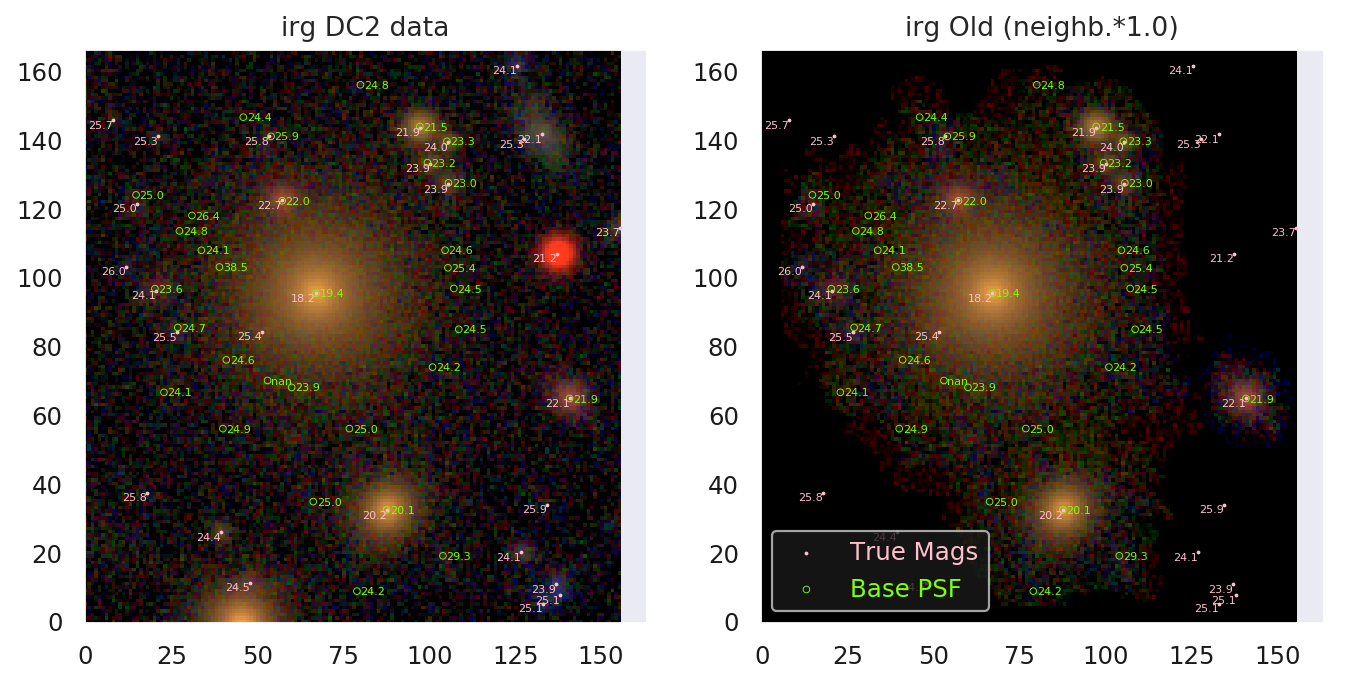

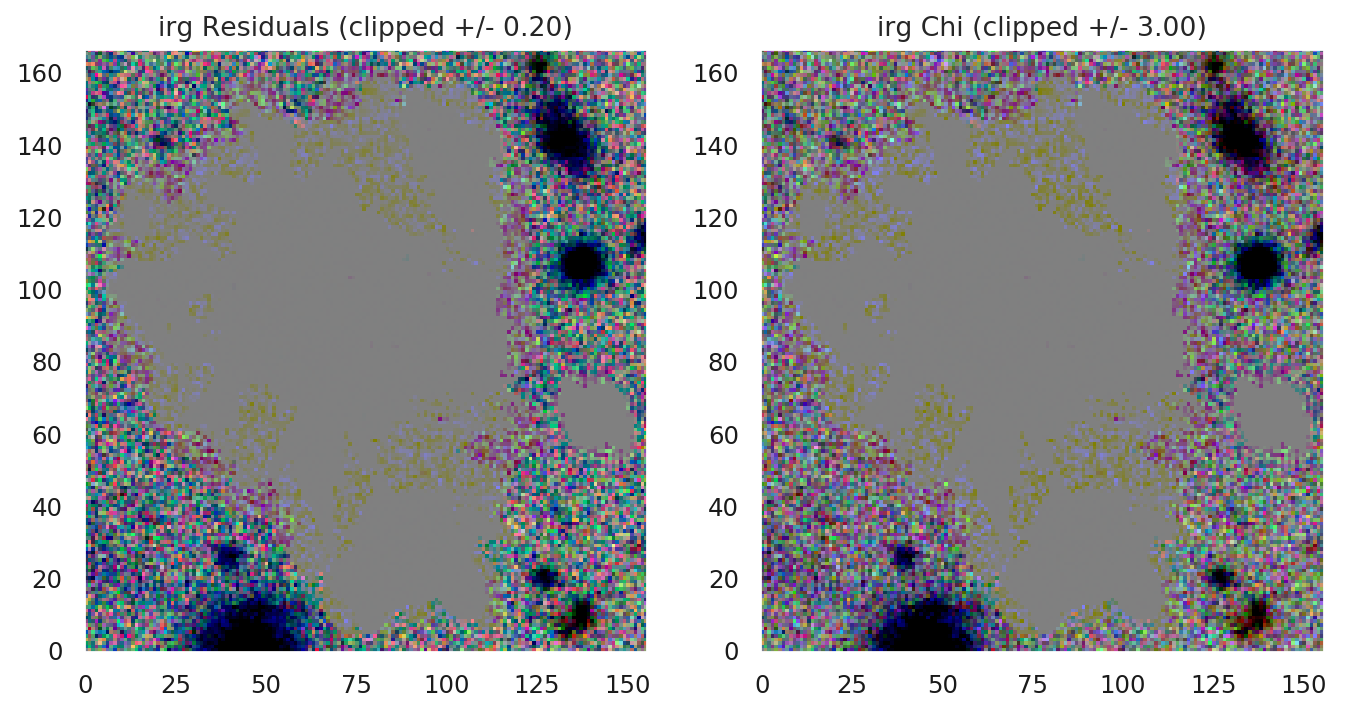

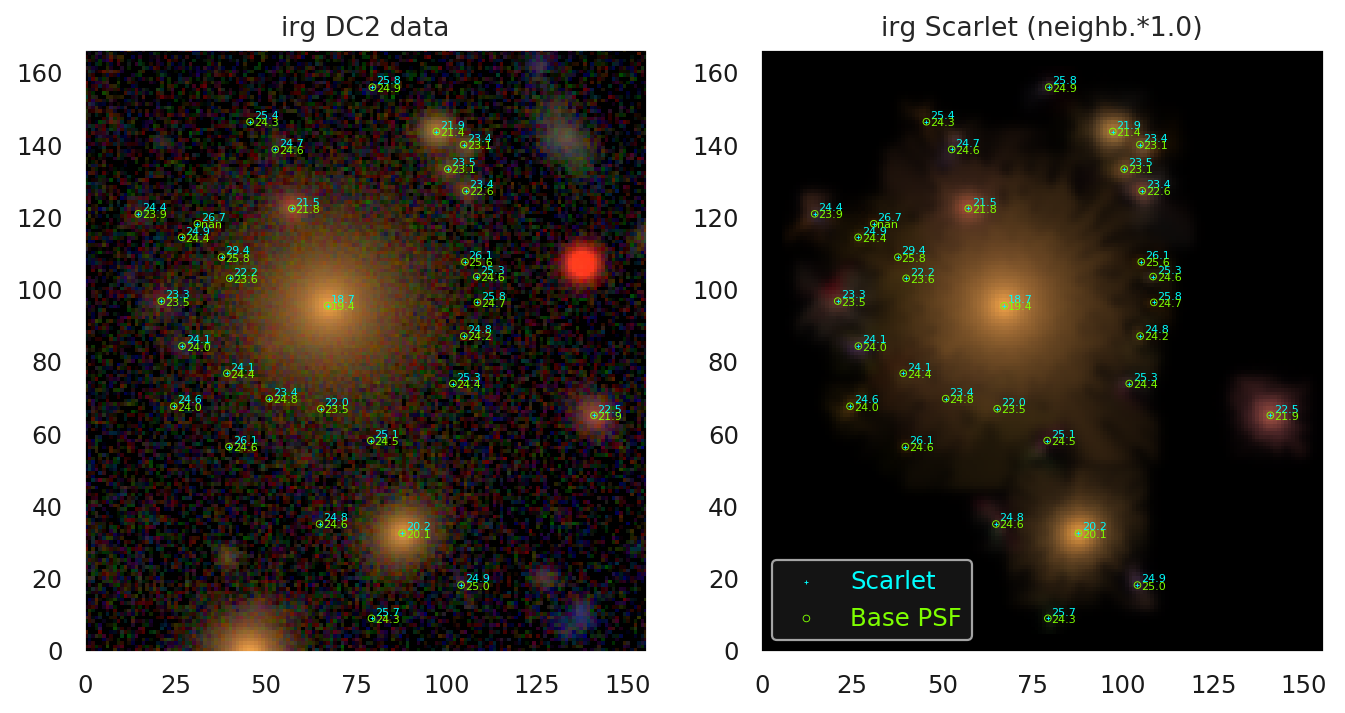

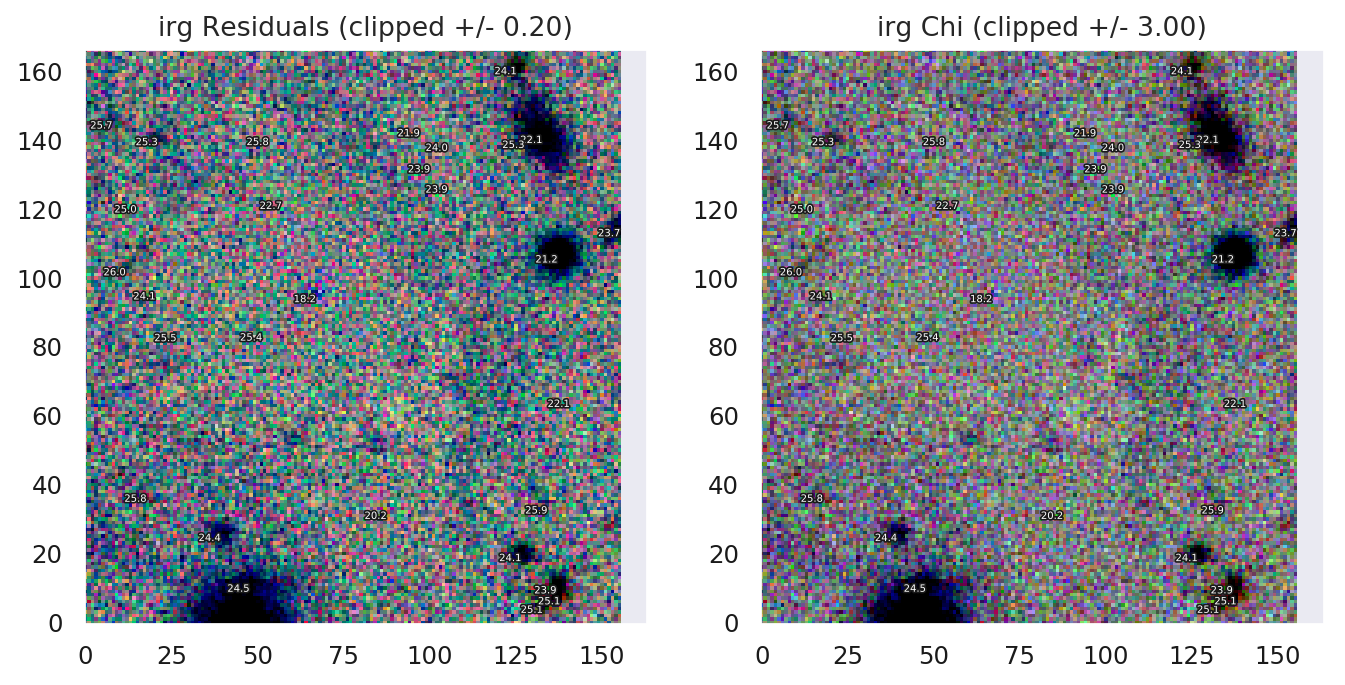

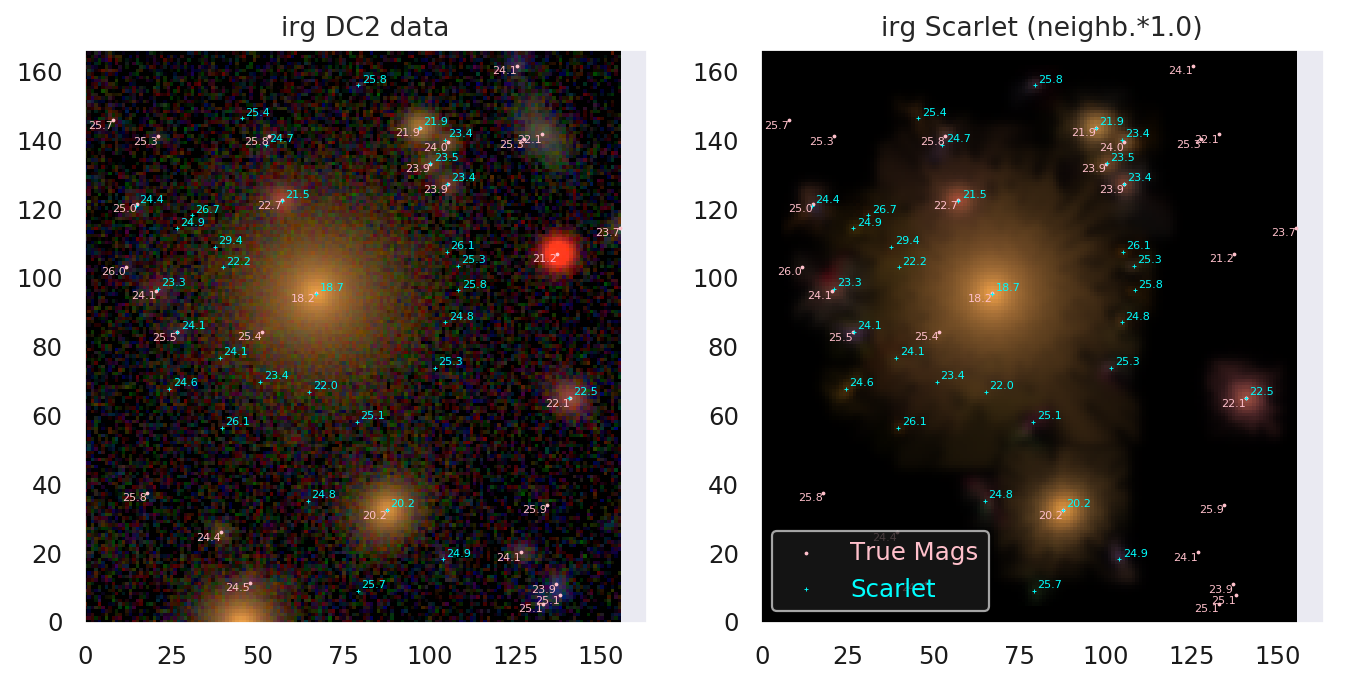

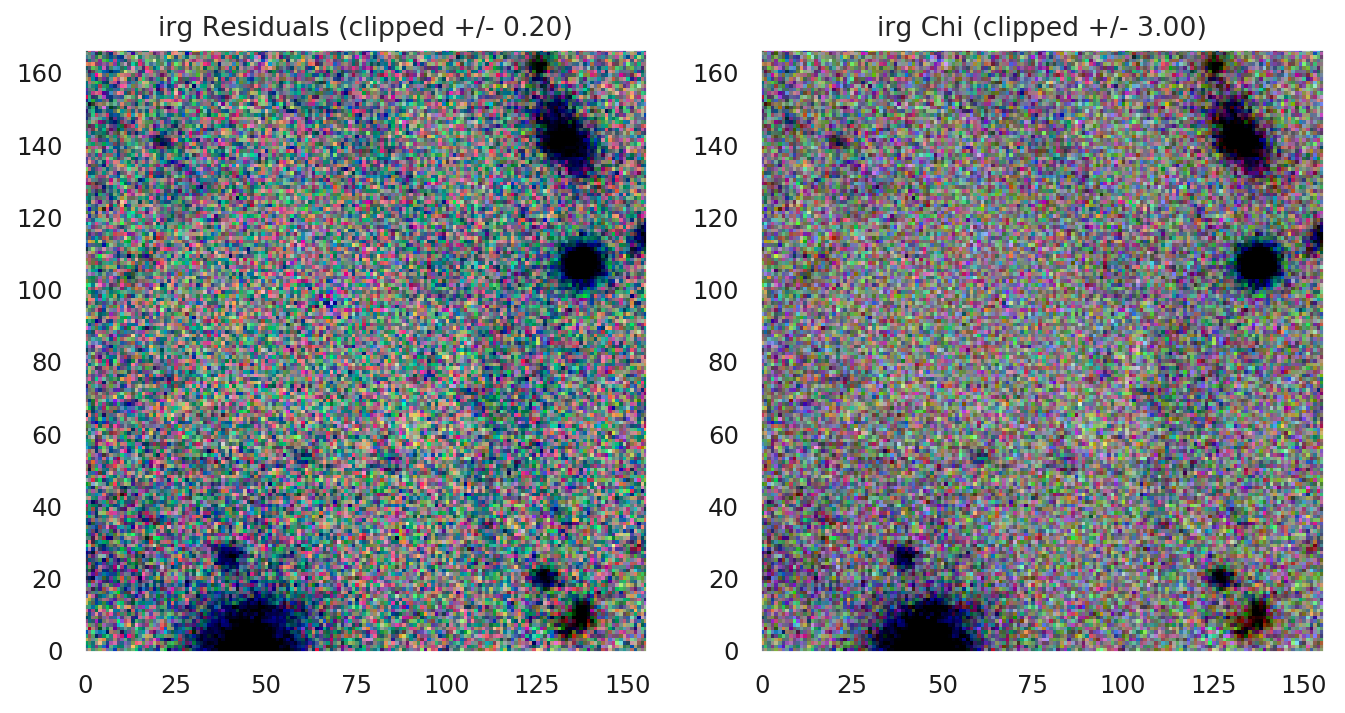

In [13]:
# Plot up the parent blend
reruns_plot = ((name_old, name_nr), (name_scarlet, name_sibsub))
bbox_xb, bbox_yb = blend.bbox.getBegin()
offset = (-bbox_xb, -bbox_yb)
measmodels = {
    name_scarlet: {'offset': offset, 'scatter_opts': dict(s=4, color='cyan', marker='+', linewidth=0.4)},
    'Base PSF': {'offset': offset, 'scatter_opts': dict(s=9, edgecolors='chartreuse', facecolors="None", marker='o', linewidth=0.4)},
}
truth = cats_dc2[f'{name_old}_{name_nr}'][tract]['truth']
sources_true = get_source_meas_all(
    bbox=blend.bbox, cat=truth, wcs=wcs_refs[name_old],
    column_mag=column_mag_true, mag_min=mag_min, zeropoint=31.4,
)
for name_deblender, name_rerun in reruns_plot:
    deblend = blend.data[name_deblender]
    meas = sources_meas[f'{name_deblender}_{name_rerun}']
    is_scarlet = name_deblender == name_scarlet
    for do_sources_true in ((False, True) if is_scarlet else (True,)):
        measmodels_plot = {name_scarlet: measmodels[name_scarlet]} if is_scarlet and do_sources_true else measmodels
        fig, ax, fig_sig, ax_sig = deblend.plot(
            bands_weights, plot_sig=True, sources=meas,
            sources_true=sources_true if do_sources_true else None,
            sources_sig=sources_true if not do_sources_true else None,
            measmodels=measmodels_plot, label_data='DC2',
            stretch=1, Q=12, residual_scale=0.2,
            show=False,
        )

Old Found: 31 80.0 156.0


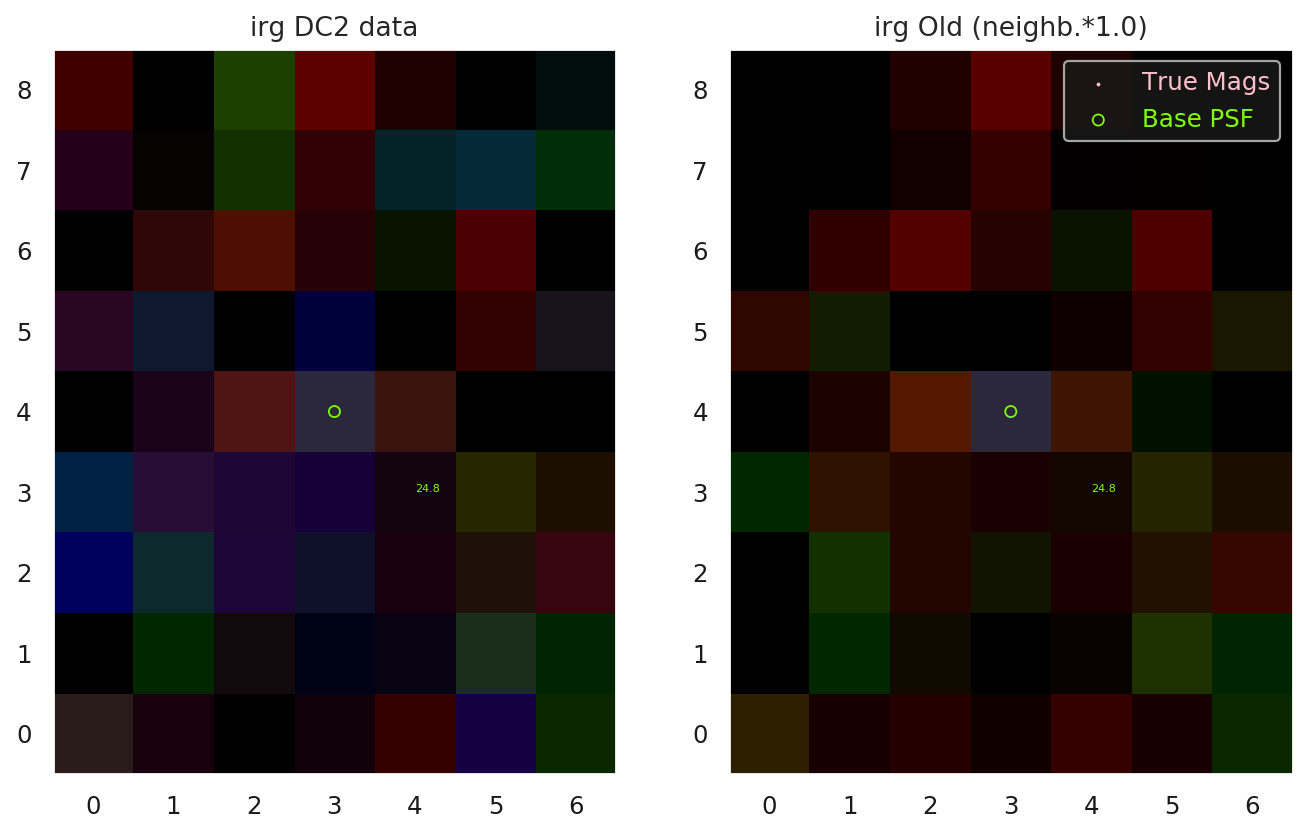

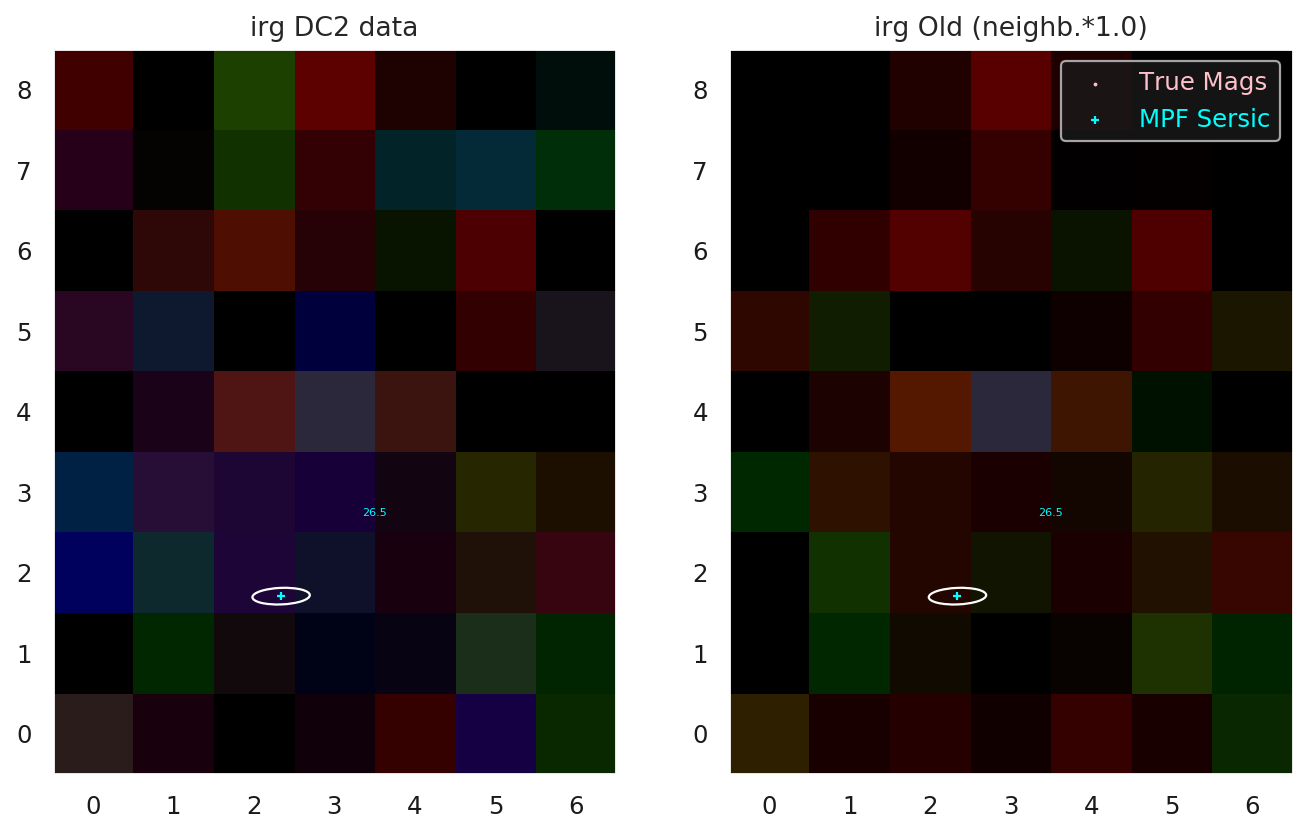

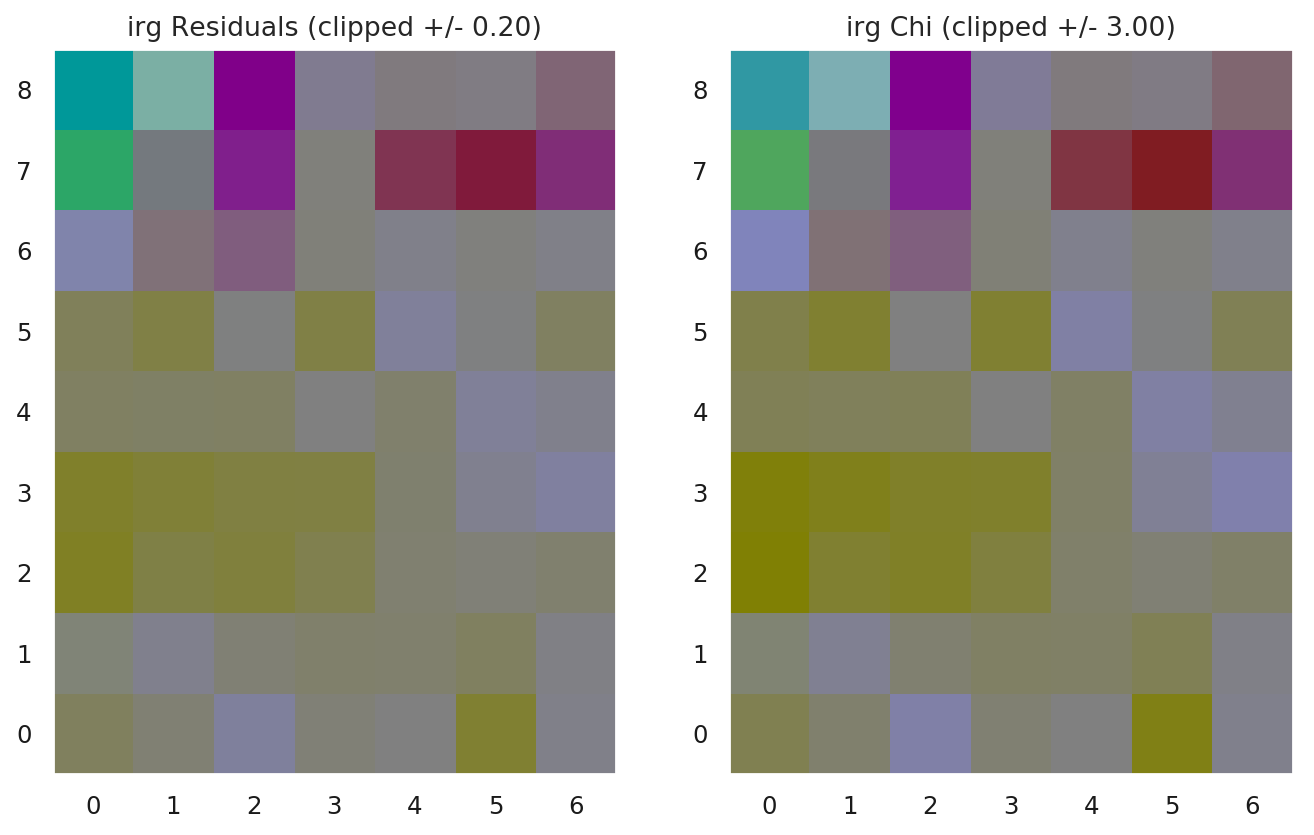

Scarlet Found: 31 73.42586315046537 150.79436214484303


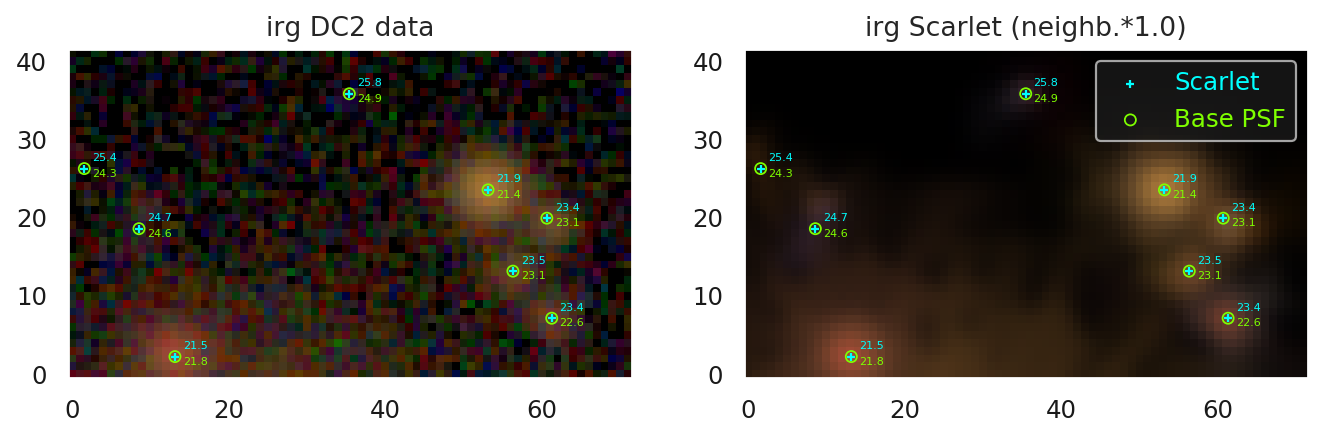

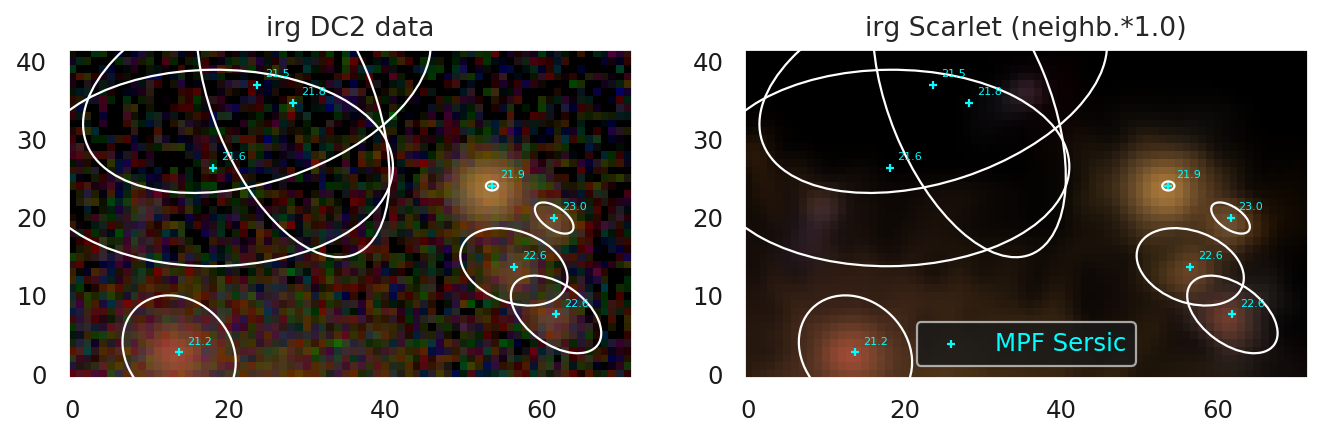

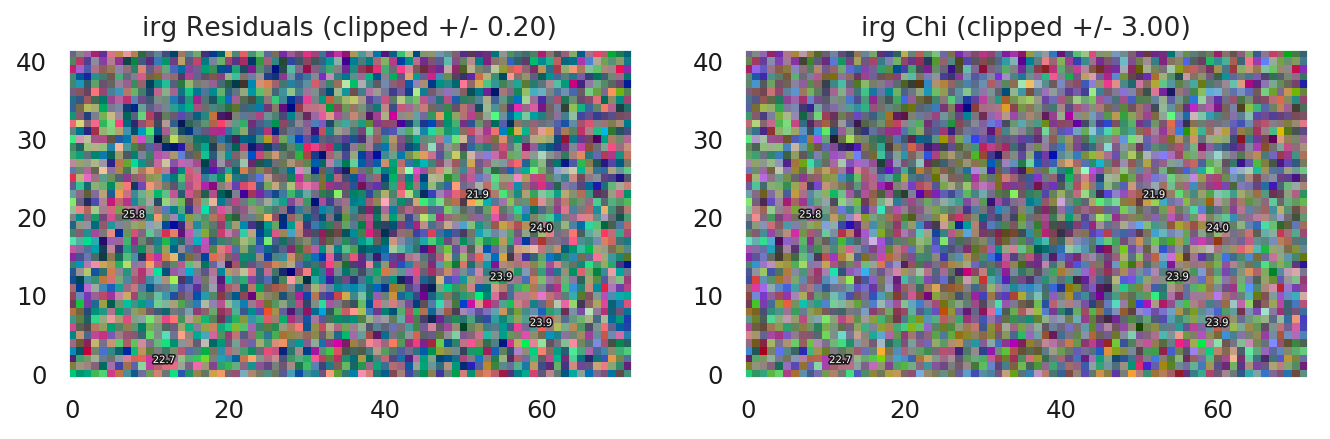

In [14]:
# Find a misbehaving child
name_model = 'Base PSF'
for name_deblender, name_rerun in reruns_plot:
    deblend = blend.data[name_deblender]
    meas = sources_meas[f'{name_deblender}_{name_rerun}']
    bbox_parent = deblend.parent.getFootprint().getBBox()
    for idx_target, src in enumerate(meas):
        x, y = (x-y for x, y in zip(src.measurements[name_model].ellipse.centroid, bbox_parent.getBegin()))
        if 75 < x < 85 and 150 < y < 160:
            break
    print(f'{name_deblender} Found:', idx_target, x, y)
    target = deblend.children[idx_target]
    bbox_child = target.getFootprint().getBBox()
    bbox_offset = bbox_child.getBegin() - bbox_parent.getBegin()
    child_width, child_height = bbox_child.getWidth(), bbox_child.getHeight()
    bbox_xb, bbox_yb = bbox_child.getBegin()
    offset = (-bbox_xb, -bbox_yb)
    measmodels_deblend = {
        'Scarlet': {'offset': offset, 'scatter_opts': dict(s=16, edgecolors='aqua', facecolors='aqua', marker='+', linewidth=1)},
        'Base PSF': {'offset': offset, 'scatter_opts': dict(s=25, edgecolors='chartreuse', facecolors='None', marker='o', linewidth=0.8)},
    }
    measmodels_fit = {
        'MPF Sersic': {'offset': offset, 'scatter_opts': dict(s=16, edgecolors='aqua', facecolors='aqua', marker='+', linewidth=1)},
    }
    sources_true_child = get_source_meas_all(
        bbox=bbox_child, cat=truth, wcs=wcs_refs[name_old],
        column_mag=column_mag_true, mag_min=mag_min, zeropoint=31.4
    )
    for measmodels_child, plot_sig in ((measmodels_deblend, False), (measmodels_fit, True)):
        _ = deblend.plot(
            bands_weights, bbox=bbox_child, plot_sig=plot_sig, sources=meas,
            sources_true=sources_true_child if name_deblender == name_old else None,
            sources_sig=sources_true_child if name_deblender == name_scarlet else None,
            measmodels=measmodels_child, label_data='DC2', stretch=1, Q=12, residual_scale=0.2,
        )

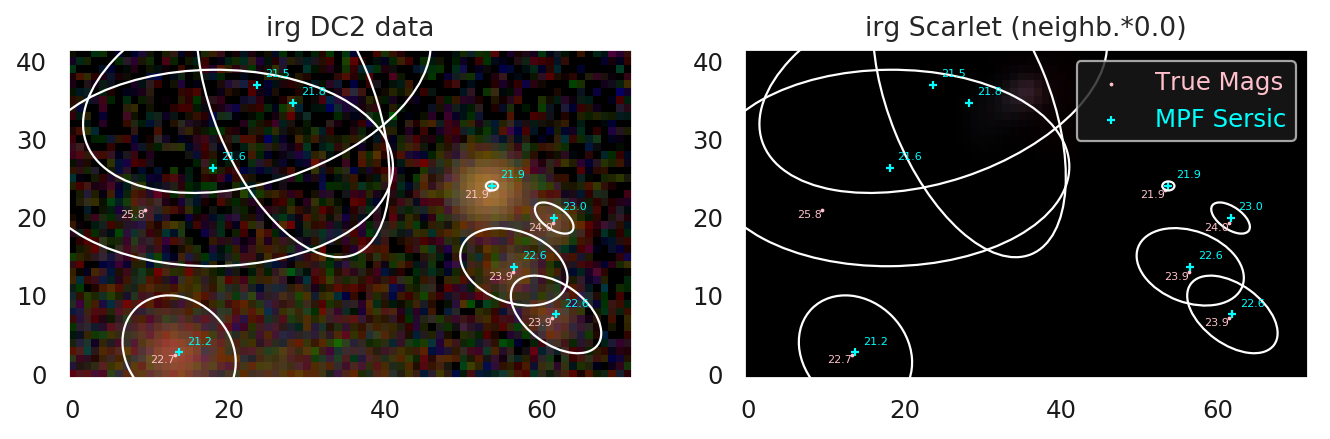

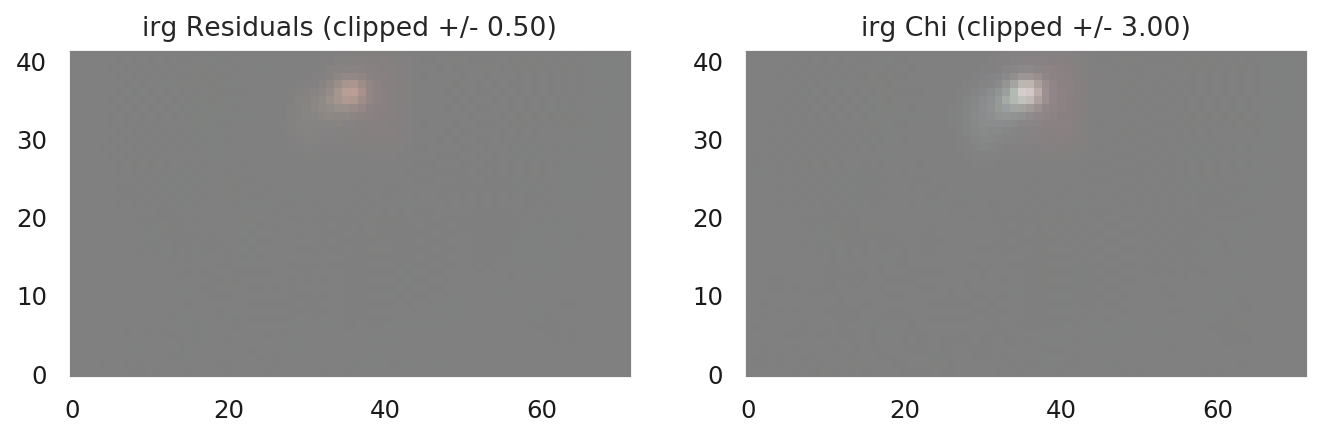

In [15]:
# Plot child data with nearby models subtracted, and residuals relative to zero (i.e. vs sky noise only)
idx_children_sub = [
    idx for idx, child_d in enumerate(deblend.children)
    if idx != idx_target and child_d.getFootprint().getBBox().overlaps(bbox_child)
]
deblend = blend.data[name_scarlet]
_ = deblend.plot(
    bands_weights, plot_sig=True, bbox=bbox_child,
    sources=sources_meas[f'{name_scarlet}_{name_sibsub}'],
    sources_true=sources_true_child,
    #sources_sig=sources_true,
    idx_children_sub=idx_children_sub,
    measmodels=measmodels_child, label_data='DC2', stretch=1, Q=12, residual_scale=0.5, data_residual_factor=0,
)

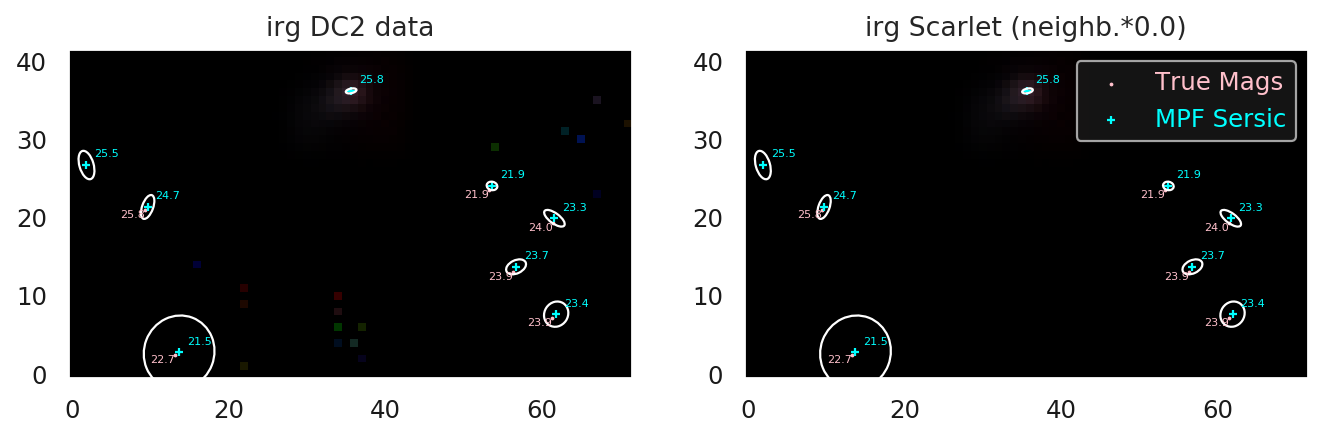

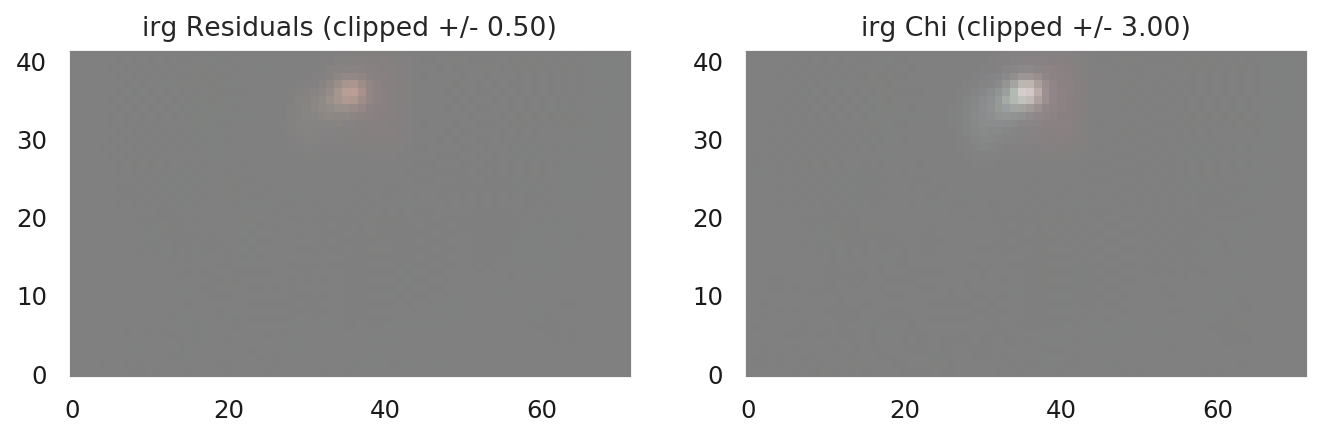

In [16]:
# Now let's do it the old noiseReplacer way
id_child = deblend.children[idx_target]['id']
for band, catexp in catexps['Scarlet'].items():
    noiseReplacer = mil.rebuildNoiseReplacer(exps_orig['Scarlet'][band], catexp.cat)
    noiseReplacer.insertSource(id_child)
_ = deblend.plot(
    bands_weights, plot_sig=True, bbox=bbox_child,
    sources=sources_meas[f'{name_scarlet}_NR'],
    sources_true=sources_true_child,
    #sources_sig=sources_true,
    idx_children_sub=idx_children_sub,
    measmodels=measmodels_child, label_data='DC2', stretch=1, Q=12, residual_scale=0.5, data_residual_factor=0,
)